# Data exploration

In [2]:
import awe.utils
awe.utils.init_notebook()

/opt/conda/envs/awe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]


In [3]:
import collections
import math
import statistics

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

In [4]:
import awe.data.parsing
import awe.data.set.apify
import awe.data.set.pages
import awe.data.set.swde
import awe.data.validation
import awe.data.visual.exploration
awe.utils.reload('awe.data')

## Load dataset

Choose between the first two or the last two cells in this section depending on whether you want to load the Apify or the SWDE dataset.

In [5]:
ds = awe.data.set.apify.Dataset(
    # only_label_keys=('name', 'price', 'category', 'images'),
    convert=False,
    # convert_slim=True,
    skip_without_visuals=True,
    # only_websites=('alzaEn',),
)

asosEn:  10%|█         | 1/10 [00:02<00:25,  2.81s/it]

Loaded 'data/apify/alzaEn/augmented_dataset.json'.


bestbuyEn:  20%|██        | 2/10 [00:04<00:15,  1.99s/it]

Loaded 'data/apify/asosEn/augmented_dataset.json'.


bloomingdalesEn:  30%|███       | 3/10 [00:07<00:18,  2.65s/it]

Loaded 'data/apify/bestbuyEn/augmented_dataset.json'.


conradEn:  40%|████      | 4/10 [00:09<00:12,  2.15s/it]       

Loaded 'data/apify/bloomingdalesEn/augmented_dataset.json'.


etsyEn:  50%|█████     | 5/10 [00:11<00:10,  2.18s/it]  

Loaded 'data/apify/conradEn/augmented_dataset.json'.


ikeaEn:  60%|██████    | 6/10 [00:12<00:07,  1.94s/it]

Loaded 'data/apify/etsyEn/augmented_dataset.json'.


notinoEn:  70%|███████   | 7/10 [00:16<00:07,  2.60s/it]

Loaded 'data/apify/ikeaEn/augmented_dataset.json'.


radioshackEn:  80%|████████  | 8/10 [00:22<00:07,  3.52s/it]

Loaded 'data/apify/notinoEn/augmented_dataset.json'.


tescoEn:  90%|█████████ | 9/10 [00:23<00:02,  2.69s/it]     

Loaded 'data/apify/radioshackEn/augmented_dataset.json'.


tescoEn: 100%|██████████| 10/10 [00:27<00:00,  2.77s/it]

Loaded 'data/apify/tescoEn/augmented_dataset.json'.


In [ ]:
pd.DataFrame(p.row for p in ds.get_all_pages()[:10])

In [ ]:
ds = awe.data.set.swde.Dataset(
    suffix='-exact',
    only_verticals=('auto',),
    # convert=False,
)

In [ ]:
pd.DataFrame(p.to_row() for p in ds.get_all_pages()[:10])

## Label statistics

This section shows a table with number of labeled nodes in each website.

In [ ]:
def get_label_stats(page: awe.data.set.pages.Page):
    page_labels = page.get_labels()
    return sum(
        (
            collections.Counter({
                k: len(page_labels.get_label_values(k)),
                #f'{k}_nodes': len(page_labels.get_labeled_nodes(k)),
            })
            for k in page_labels.label_keys
        ),
        collections.Counter()
    )

stats = [
    sum(
        (
            get_label_stats(p)
            for p in tqdm(w.pages, desc=w.name, disable=True)
            if w.page_count != 0
        ),
        collections.Counter()
    )
    for w in tqdm(ds.verticals[0].websites, desc='websites')
]
keys = { k for s in stats for k in s.keys() }

In [ ]:
df = pd.DataFrame([
    {
        'website': w.name,
        'domain': w.get_domain(),
        'pages': w.page_count,
    }
    | {
        k: 0
        for k in keys
    } | {
        k: c #f'{c} ({c / w.page_count:.0%})'
        for k, c in s.items()
    }
    for w, s in zip(ds.verticals[0].websites, stats)
])
# Add totals.
df.loc['total'] = df.sum()
df.loc['total', ('website', 'domain')] = ''
# Sort columns by name.
df = df.reindex(
    sorted(
        df.columns,
        key=lambda n: f'_{n}' if n in ('website', 'domain', 'pages') else n
    ),
    axis=1
)
df

Here, the table is turned into LaTeX code to be used in the thesis (to avoid manual and error-prone filling).

In [ ]:
# Generate LaTeX table.
if ds.name == 'apify':
    columns = ('name', 'price', 'category', 'images', 'shortDescription', 'longDescription', 'specification')
    display_cols = {
        'category': 'cat',
        'shortDescription': 'short',
        'longDescription': 'long',
        'specification': 'spec'
    }
    split_nv = False
else:
    columns = ('model', 'price', 'engine', 'fuel_economy')
    display_cols = {
        'fuel_economy': 'economy'
    }
    split_nv = True
if split_nv:
    print('&', end=' ')
else:
    print('website & pages', end=' ')
for col in columns:
    col = display_cols.get(col, col)
    print(f'& \\akcol{{{col}}}', end=' ')
print('\\\\')
if split_nv:
    print('website & pages', end=' ')
    for col in columns:
        print('& \\akvn', end=' ')
    print('\\\\')
print('\\midrule')
for w, s in zip(ds.verticals[0].websites, stats):
    name = w.get_domain() \
        .removeprefix('www.') \
        .removesuffix('.com') \
        .removesuffix('.co.uk')
    print(f'\\verb|{name}|', end=' ')
    print(f'& {w.page_count:,}', end=' ')
    for col in columns:
        if split_nv:
            print(f'& {s[col]:,}', end=' ')
        print(f'& {s[f"{col}_nodes"]:,}', end=' ')
    print('\\\\')
print('\\bottomrule')
print('total', end=' ')
print(f'& {sum(w.page_count for w in ds.verticals[0].websites):,}', end=' ')
for col in columns:
    if split_nv:
        print(f'& {sum(s[col] for s in stats):,}', end=' ')
    print(f'& {sum(s[f"{col}_nodes"] for s in stats):,}', end=' ')
print('\\\\')

## Node statistics

This section shows table with median number of DOM nodes in each website.

In [17]:
# Number of nodes (median across pages) in each website.
def get_num_nodes(page: awe.data.set.pages.Page):
    html_text = page.get_html_text()
    tree = awe.data.parsing.parse_html(html_text)
    awe.data.parsing.filter_tree(tree)
    nodes = tree.root.traverse(include_text=True)
    return sum(1 for _ in nodes)
def get_median_nodes(website: awe.data.set.pages.Website):
    return math.floor(statistics.median(
        get_num_nodes(p)
        for p in website.pages
    ))
median_stats = [
    get_median_nodes(w)
    for w in tqdm(ds.verticals[0].websites, desc='websites')
]

websites: 100%|██████████| 1/1 [00:11<00:00, 11.24s/it]


In [18]:
df = pd.DataFrame([
    {
        'website': w.name,
        'domain': w.get_domain(),
        'pages': w.page_count,
        'nodes': m,
    }
    for w, m in zip(ds.verticals[0].websites, median_stats)
])
print(f'Average: {df.nodes.mean()}')
print(f'std: {df.nodes.std()}')
df

Average: 1428.0
std: nan


website          domain  pages  nodes
0  alzaEn  www.alza.co.uk   2493   1428

## Explore

In [8]:
from awe.data.visual.exploration import PageExplorer

page = ds.verticals[0].websites[0].pages[0]


pe = PageExplorer(page)




print(pe.page_labels.label_keys)

['category', 'images', 'longDescription', 'name', 'price', 'shortDescription', 'specification']


/workspaces/anaconda/awe/awe/data/set/apify.py:476: UserWarning: Removed empty nodes labeled specification (selector='.params') in 'alzaEn'.
  warnings.warn(


In [32]:
from awe.data.visual.exploration import PageExplorer

# page = ds.verticals[0].websites[0].pages[0]

# print(ds.verticals[0].websites[0].get_domain())
# print(pe.page_labels.label_keys)


for page in ds.verticals[0].websites:
  pe = PageExplorer(page)
  for category in keys:
      nodes = pe.page_labels.get_labeled_nodes(category)
      for node in nodes:
          parsed_node = pe.page_dom.find_parsed_node(node)
          if parsed_node is not None:
              print(category, parsed_node.box)   








www.alza.co.uk
['category', 'images', 'longDescription', 'name', 'price', 'shortDescription', 'specification']
images BoundingBox(x=30, y=254, width=525, height=649)
longDescription BoundingBox(x=30, y=1862.90625, width=975, height=456.90625)
name BoundingBox(x=645, y=224, width=390, height=86)
price BoundingBox(x=930.765625, y=871.375, width=64.234375, height=35)
shortDescription BoundingBox(x=645, y=370, width=360, height=75)
specification BoundingBox(x=30, y=2349.8125, width=975, height=211.3125)


In [6]:
import json
from awe.data.visual.exploration import PageExplorer


category_index_map: dict[str, int] = dict()
category_max_index = 0

for website in ds.verticals[0].websites[6:]:
    print(website.name)
    output_data = []
    for idx, page in enumerate(tqdm(website.pages)):
        pe = PageExplorer(page)
        image_id = pe.page.file_name_no_extension
        file_name = pe.page.screenshot_file_name
        objects = {"bbox": [], "categories": []}
        annotations = []

        for category in pe.page_labels.label_keys:
            
            category_index = category_index_map.get(category)
            if category_index is None:
                category_index_map[category] = category_max_index
                category_max_index += 1

            nodes = pe.page_labels.get_labeled_nodes(category)
            for node_id, node in enumerate(nodes, start=1):
                parsed_node = pe.page_dom.find_parsed_node(node)
                if parsed_node is not None:
                    box = parsed_node.box
                    if box is not None:
                        bbox = [box.x, box.y, box.width, box.height]
                        objects["bbox"].append(bbox)
                        objects["categories"].append(category_index)

                        annotation = {
                            "id": node_id,
                            "image_id": image_id,
                            "category_id": category_index,
                            "segmentation": [],
                            "area": box.width * box.height,
                            "bbox": bbox,
                            "iscrowd": 0,
                            "attributes": {"occluded": False, "rotation": 0.0}
                        }
                        annotations.append(annotation)

        record = {
            "image_id": image_id,
            "file_name": file_name,
            "height": None,
            "width": None,
            "objects": objects,
            "annotations": annotations
        }
        output_data.append(record)

    # Save the output data as a JSON lines file
    with open(f'metadata-{website.name}.jsonl', 'w') as outfile:
        for entry in output_data:
            json.dump(entry, outfile)
            outfile.write('\n')


ikeaEn


100%|██████████| 1972/1972 [01:47<00:00, 18.39it/s]


notinoEn


100%|██████████| 2000/2000 [02:00<00:00, 16.64it/s]


radioshackEn


100%|██████████| 499/499 [00:23<00:00, 21.15it/s]


tescoEn


  0%|          | 0/1500 [00:00<?, ?it/s]/workspaces/anaconda/awe/awe/data/set/apify.py:453: UserWarning: Patched specification selector '.product-info-block + section.tabularContent, div.product-info-block--undefined, div.product-info-block--undefined~.product-info-block' to '.product-info-block ~ section.tabularContent, div.product-info-block--undefined, div.product-info-block--undefined~.product-info-block' in 'tescoEn'.
  warnings.warn(f'Patched {label_key} selector {selector!r} to ' +
  0%|          | 5/1500 [00:00<01:27, 17.08it/s]/workspaces/anaconda/awe/awe/data/set/apify.py:476: UserWarning: Removed empty nodes labeled longDescription (selector='div.product-info-block:not(.product-info-block--undefined, .product-info-block--undefined~.product-info-block)') in 'tescoEn'.
  warnings.warn(
100%|██████████| 1500/1500 [01:05<00:00, 23.08it/s]


In [7]:
import glob
import shutil

def combine_jsonl_files_efficient():
    # Get a list of all files in the current directory that match the pattern 'metadata-*.jsonl'
    files = glob.glob('metadata-*.jsonl')

    # Open the output file
    with open('metadata.jsonl', 'wb') as outfile:
        # Loop through the list of files
        for file in files:
            # Open the current file and copy its contents to the output file
            with open(file, 'rb') as infile:
                shutil.copyfileobj(infile, outfile)

# Run the function
combine_jsonl_files_efficient()

: 

## Screenshots

This section shows screenshots of pages with target nodes highlighted (by drawing their bounding boxes).

/workspaces/anaconda/awe/awe/data/set/apify.py:453: UserWarning: Patched shortDescription selector '.mb-3.d-xl-flex section:has(+ section:has([data-navigate-to="#product-description-full"])).section.section--sm.section--vertical' to '.mb-3.d-xl-flex section:has(~ section:has([data-navigate-to="#product-description-full"])).section.section--sm.section--vertical' in 'conradEn'.
  warnings.warn(f'Patched {label_key} selector {selector!r} to ' +
/workspaces/anaconda/awe/awe/data/set/apify.py:453: UserWarning: Patched specification selector '.product-info-block + section.tabularContent, div.product-info-block--undefined, div.product-info-block--undefined~.product-info-block' to '.product-info-block ~ section.tabularContent, div.product-info-block--undefined, div.product-info-block--undefined~.product-info-block' in 'tescoEn'.
  warnings.warn(f'Patched {label_key} selector {selector!r} to ' +
pages: 100%|██████████| 10/10 [00:01<00:00,  9.82it/s]


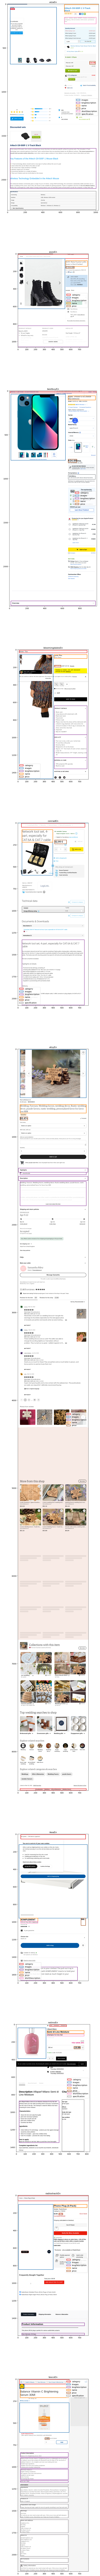

In [29]:
websites = ds.verticals[0].websites
_ = awe.data.visual.exploration.plot_websites(websites, n_cols=1)

## HTML tag statistics

This section shows the distribution of HTML tag names labeled as `images` (in the Apify dataset).

In [ ]:
# Which HTML tags are labeled as images?
def get_page_dom(page: awe.data.set.pages.Page):
    page_dom = page.dom
    if page_dom.root is None:
        page_dom.init_nodes()
        page_dom.init_labels(propagate_to_leaves=True)
    return page_dom
rng = np.random.default_rng(42)
{
    w.name: collections.Counter(
        html_tag
        for p in rng.choice(w.pages, 5, replace=False)
        for html_tag in set(
            node.html_tag
            for labeled_nodes in get_page_dom(p).labeled_nodes.get('images', ())
            for node in labeled_nodes
        )
    )
    for w in tqdm(ds.verticals[0].websites, desc='websites')
}

## DOM exploration

This section begins exploring DOM of one page.

### Load a page

A page can be either loaded from the external list of invalid pages (produced by our validation code)...

In [ ]:
with open('data/invalid_pages.txt', mode='r', encoding='utf-8') as f:
    file_path = f.readline().rstrip()
page = next(p for p in ds.get_all_pages() if p.original_html_path == file_path)
page

...or simply one sample selected from the dataset.

In [ ]:
page = ds.verticals[0].websites[0].pages[0]
page

### Prepare page

Here, page DOM and visuals are loaded.

In [ ]:
page.url, page.html_path

In [ ]:
page.clear_cache(awe.data.set.pages.ClearCacheRequest())

In [ ]:
page_labels = page.get_labels()
page_dom = page.cache_dom()

In [ ]:
page_dom.init_nodes()
len(page_dom.nodes)

In [ ]:
page_visuals = page.load_visuals()
page_visuals.fill_tree(page_dom)

In [ ]:
page_dom.filter_nodes()
len(page_dom.nodes)

In [ ]:
# Mark all text fragments with visuals as "sampled".
for node in page_dom.nodes:
    node.sample = node.is_text and node.box is not None

### Explore labels

This section shows labeled nodes in the page.

In [ ]:
{ k: v for k, v in page.row.items() if k.startswith('selector_') }

In [ ]:
page_dom.init_labels(propagate_to_leaves=True)
{
    k: [[n.get_xpath() for n in g] for g in v]
    for k, v in page_dom.labeled_nodes.items()
}

In [ ]:
pd.DataFrame({
        'label_key': k,
        'xpath': n.get_xpath(),
        'text': n.parsed.text(),
        'tag': n.find_semantic_html_tag(),
        'box': n.box.as_tuple()
    }
    for k, v in page.dom.labeled_nodes.items()
    for g in v
    for n in g[:1]
)

In [ ]:
{
    k: page_labels.get_label_values(k)
    for k in page_labels.label_keys
}

In [ ]:
{
    k: [
        n.text()
        for n in page_labels.get_labeled_nodes(k)
    ]
    for k in page_labels.label_keys
}

### Visual neighbors

This section shows visual neighbors of target nodes (what the model will see).

In [ ]:
page_dom.compute_visual_neighbors()

In [ ]:
page_dom.compute_visual_neighbors_rect()

In [ ]:
pd.DataFrame({
        'label_key': k,
        'text': n.parsed.text()
    } | {
        f'neighbor_{i}': (m.distance_x, m.distance_y, m.neighbor.get_text_or_tag())
        for i, m in enumerate(n.visual_neighbors)
    }
    for k, v in page.dom.labeled_nodes.items()
    for g in v
    for n in g
)

### Friend cycles

This section shows friends of target nodes (what the model will see).

In [ ]:
page_dom.compute_friend_cycles(max_ancestor_distance=5)

In [ ]:
price_node = page_dom.labeled_nodes['price'][0][0]
text_nodes = [n for n in price_node.traverse() if n.is_text]
[(n.text, n.partner.text if n.partner else None) for n in text_nodes]

In [ ]:
target_node = text_nodes[0]
pd.DataFrame([{
    'tag': n.html_tag,
    'index': n.deep_index,
    'distance': n.deep_index - target_node.deep_index,
    'text': n.parsed.text()
 } for n in target_node.friends or ()])